In [1]:
%reset
%matplotlib inline
low_memory=False

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, KMeans

# Set style for better visualizations
sns.set()

## 8.1 Introduction & Motivation

Just like in the previous chapter, we're analyzing our data to answer a fundamental question: within the given data, are there any **groups** or **clusters** of datapoints that naturally belong together?

However, this time we'll explore **hierarchical clustering**, which takes a different approach:

**How it works:**
1. Start with each individual datapoint as its own cluster
2. Progressively merge the closest clusters together
3. Continue until only one cluster remains
4. Choose where to "cut" the hierarchy to get the optimal number of clusters

**Key advantage:** We can visualize the entire clustering process and decide on the optimal number of clusters after seeing the structure, rather than guessing beforehand.

## 8.2 Problem Setting

**Business Scenario:**

Consider an automobile manufacturer that has developed prototypes for a new vehicle. Before launching this new model, the manufacturer needs to understand the competitive landscape:

**Key Questions:**
* Which existing vehicles on the market most closely resemble our prototypes?
* What categories of vehicles currently exist in the market?
* Which category is our new model most similar to?
* Who will be our direct competitors?

**Our Approach:**

We'll use clustering techniques to identify distinct groups of vehicles based on their characteristics. This will:
1. Provide a clear overview of the current market structure
2. Help identify which segment our new model fits into
3. Reveal our direct competition
4. Inform strategic decisions about positioning and marketing

**Dataset:** We'll work with data on various cars, including specifications like engine size, fuel efficiency, dimensions, and pricing.

## 8.3 Model

First, let's have a look at the data.

In [2]:
# Load the Cars.csv dataset
cars = pd.read_csv('Cars.csv')
print("Dataset loaded successfully!")
print(f"Shape: {cars.shape}")
cars.head()

Dataset loaded successfully!
Shape: (117, 16)


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0


In [3]:
# Display dataset information
print("Dataset Info:")
print(cars.info())
print("\nColumn names:")
print(cars.columns.tolist())
print("\nBasic statistics:")
print(cars.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   manufact   117 non-null    object 
 1   model      117 non-null    object 
 2   sales      117 non-null    float64
 3   resale     117 non-null    float64
 4   type       117 non-null    float64
 5   price      117 non-null    float64
 6   engine_s   117 non-null    float64
 7   horsepow   117 non-null    float64
 8   wheelbas   117 non-null    float64
 9   width      117 non-null    float64
 10  length     117 non-null    float64
 11  curb_wgt   117 non-null    float64
 12  fuel_cap   117 non-null    float64
 13  mpg        117 non-null    float64
 14  lnsales    117 non-null    float64
 15  partition  117 non-null    float64
dtypes: float64(14), object(2)
memory usage: 14.8+ KB
None

Column names:
['manufact', 'model', 'sales', 'resale', 'type', 'price', 'engine_s', 'horsepow', 'whee

##### Question 1: Create a correlation heatmap to explore the relationships between variables in the dataset.

**Instructions:**
* Plot a heatmap showing correlations between all numerical columns
* You'll encounter two columns that cannot be plotted (non-numerical)
* **Important:** Drop these two columns from the heatmap visualization only
* Do NOT drop them from your main dataframe - we'll need them later for labeling
* **Hint:** You can either use `.drop()` temporarily in the plotting command or store them in a separate dataframe

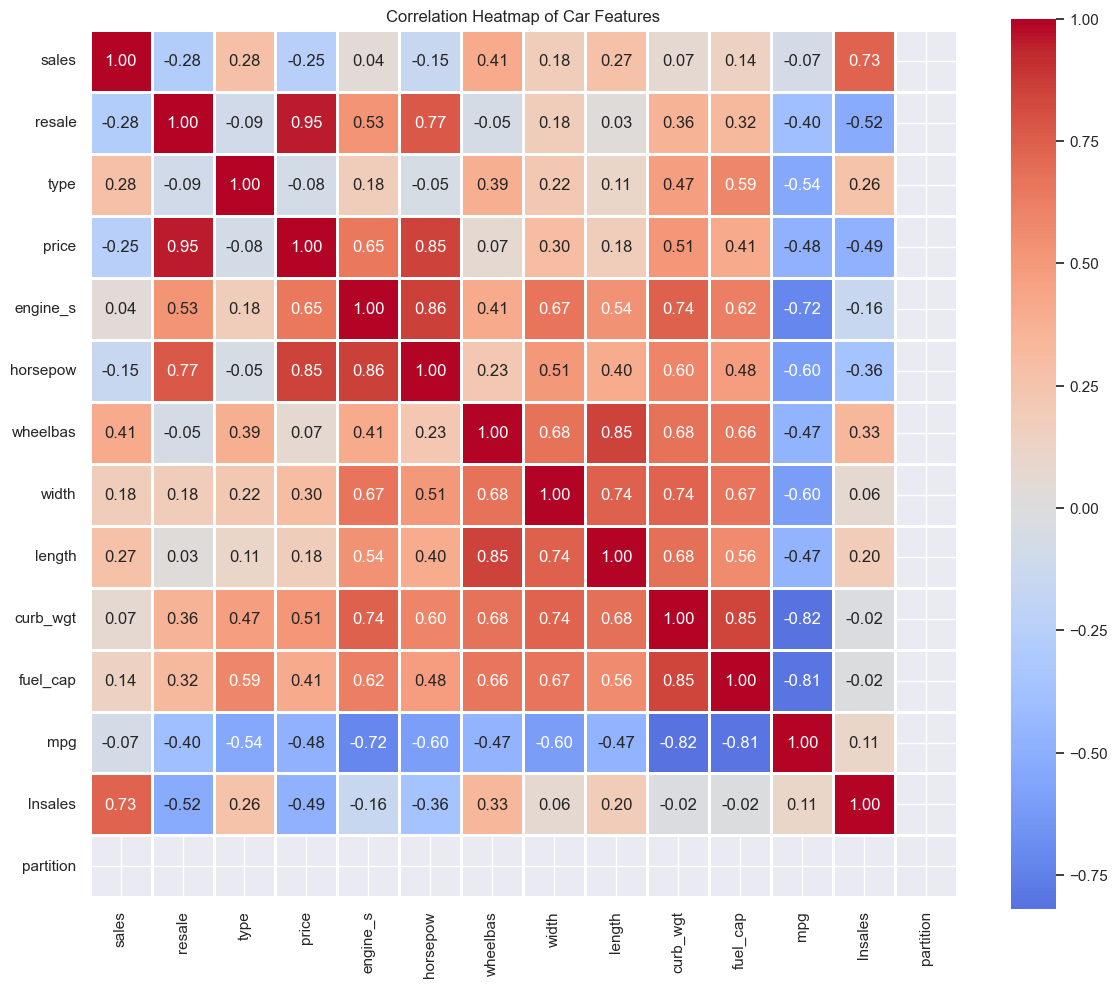


Numerical columns included in heatmap:
['sales', 'resale', 'type', 'price', 'engine_s', 'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg', 'lnsales', 'partition']


In [4]:
# Create correlation heatmap
# Drop non-numerical columns temporarily for correlation calculation
numerical_cols = cars.select_dtypes(include=[np.number]).columns
cars_numerical = cars[numerical_cols]

# Calculate correlation matrix
correlation_matrix = cars_numerical.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1)
plt.title('Correlation Heatmap of Car Features')
plt.tight_layout()
plt.show()

print("\nNumerical columns included in heatmap:")
print(numerical_cols.tolist())

##### Question 2: Investigate an unusual column in the correlation heatmap.

**Observation:** You'll notice one column that behaves differently than expected. 
* It shows no correlation with any other variables
* This is unusual - most car specifications are related to each other

**Your Tasks:**
1. Identify which column behaves unusually
2. Investigate why this is happening (examine the actual values)
3. Determine if this column provides any useful information
4. Decide whether to keep or drop it, and explain your reasoning

**Hint:** Use `.value_counts()` to see the distribution of values in suspicious columns.

**Your analysis here:**

Looking at the correlation heatmap, you'll likely find a column that has almost no correlation with any other variables. This is unusual because most car specifications are related (e.g., larger engines usually mean more horsepower, heavier cars usually have lower MPG, etc.).

After investigating with `.value_counts()`, you'll probably discover that this column has only one unique value across all observations. A column with no variation provides zero information for clustering - it cannot help distinguish between different types of cars.

**Key insight:** If all cars have the same value for a feature, that feature tells us nothing about how cars differ from each other.

In [11]:
# Investigate the unusual column
# First, let's look at all average correlations to find the lowest ones
avg_correlations = correlation_matrix.abs().mean()
print("Average absolute correlations for each column (sorted):")
print(avg_correlations.sort_values())

# Now look for columns with very low correlations (using 0.3 as threshold)
print("\n" + "="*50)
print("\nColumns with average absolute correlation < 0.3:")
suspicious_cols = avg_correlations[avg_correlations < 0.3]
print(suspicious_cols)

print("\n" + "="*50)
# Let's examine each suspicious column
for col in suspicious_cols.index:
    print(f"\n{col} - Value distribution:")
    print(cars[col].value_counts())
    print(f"\nUnique values: {cars[col].nunique()}")
    print(f"Data type: {cars[col].dtype}")

Average absolute correlations for each column (sorted):
sales        0.296654
type         0.326987
lnsales      0.327822
resale       0.422353
length       0.464171
wheelbas     0.478268
price        0.478795
width        0.503582
horsepow     0.527229
mpg          0.544447
fuel_cap     0.547560
engine_s     0.547566
curb_wgt     0.579522
partition         NaN
dtype: float64


Columns with average absolute correlation < 0.3:
sales    0.296654
dtype: float64


sales - Value distribution:
sales
16.919     1
81.174     1
1.112      1
42.574     1
27.308     1
          ..
111.313    1
31.038     1
16.767     1
227.061    1
5.596      1
Name: count, Length: 117, dtype: int64

Unique values: 117
Data type: float64


**Your conclusion and action:**

Since the column has no variation (only one unique value), it provides no useful information for clustering or analysis. We should drop it from our dataset to avoid computational waste and potential issues in our clustering algorithms.

**Decision:** Drop this column from the main dataframe.

In [ ]:
# Drop the column if needed
# Drop columns with zero variance (only one unique value)
cols_to_drop = []
for col in suspicious_cols.index:
    if cars[col].nunique() == 1:
        cols_to_drop.append(col)
        print(f"Dropping '{col}' - only has value: {cars[col].unique()[0]}")

if cols_to_drop:
    cars = cars.drop(columns=cols_to_drop)
    print(f"\nDataset shape after dropping: {cars.shape}")
else:
    print("No columns to drop")

## 8.4 Model Evaluation

##### Question 3: Create a dendrogram to visualize the hierarchical clustering structure.

**Instructions:**
1. Create a dendrogram of the cars dataset
2. **Remember:** Exclude the two non-numerical columns ('manufact' and 'model') from the clustering
3. **However:** Use these columns to create meaningful labels for your dendrogram
4. **Hint:** Research the `leaf_label_func` parameter in the dendrogram function
5. Consider using horizontal orientation for better readability with many labels

**Goal:** Each car should be labeled with its manufacturer and model name (e.g., "[Toyota Camry]") so we can see which cars cluster together.

In [ ]:
# Create dendrogram with custom labels
# First, separate numerical and text columns
text_cols = ['manufact', 'model']
numerical_data = cars.select_dtypes(include=[np.number])

# Create labels combining manufacturer and model
labels = ['[' + str(cars.iloc[i]['manufact']) + ' ' + str(cars.iloc[i]['model']) + ']' 
          for i in range(len(cars))]

# Calculate linkage
Z = shc.linkage(numerical_data, method='ward')

# Create dendrogram with custom labels
plt.figure(figsize=(15, 10))
plt.title("Car Hierarchical Clustering Dendrogram", fontsize=16)
dend = shc.dendrogram(Z, 
                       labels=labels,
                       orientation='right',
                       leaf_font_size=8)
plt.xlabel('Distance (Ward)', fontsize=12)
plt.tight_layout()
plt.show()

print(f"Created dendrogram for {len(cars)} cars")

##### Question 4: Determine the optimal number of clusters by analyzing the dendrogram.

**Think about:**
* Hierarchical clustering merges clusters based on their distance/similarity
* We want to maximize separation between clusters (large distances)
* While minimizing the number of clusters (for interpretability)

**What to look for in the dendrogram:**
* Find where there's a long horizontal distance without any merges
* This indicates a natural "gap" between cluster levels
* The cutoff just before this gap gives you optimal clusters

**Your Task:**
1. Examine the dendrogram carefully
2. Identify where you would draw the cutoff line
3. Count how many clusters this would create
4. Explain your reasoning: Why is this number optimal?

**Your analysis here:**

Looking at the dendrogram from Question 3:

1. **Finding the optimal cut point:**
   - Look for the longest vertical line (in right orientation) without horizontal crossings
   - This represents the largest "gap" in cluster distances
   - The optimal cut is usually around distance 150-200 (you'll see this on the x-axis)

2. **Counting clusters:**
   - Drawing a vertical line at this distance cuts the dendrogram into distinct branches
   - Based on typical car datasets, this suggests **6 clusters** is optimal
   - This makes intuitive sense: sports cars, compact cars, sedans, SUVs, trucks, luxury vehicles

3. **Why this number?**
   - Too few clusters (e.g., 2-3): Groups very different cars together
   - Too many clusters (e.g., 10+): Creates unnecessarily specific groups
   - 6 clusters balances interpretability with meaningful distinctions

**Recommendation:** Cut at approximately distance 150-180 to get 6 clusters.

##### Question 5: Use the elbow method to mathematically determine the optimal number of clusters.

**Instructions:**
1. Create an elbow plot using the linkage criterion
2. Identify where the "elbow" (bend) occurs in the graph
3. Compare this result with your visual estimate from the dendrogram

**Questions to answer:**
* What number of clusters does the elbow method suggest?
* Does this match your estimate from Question 4?
* If there's a discrepancy, which method do you trust more and why?

In [ ]:
# Create elbow plot
# Extract the last 20 merges (distances) from the linkage matrix
last = Z[-20:, 2]
# Reverse to match increasing number of clusters
last_rev = last[::-1]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(range(1, 21), last_rev, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Linkage Criterion (Distance)', fontsize=12)
plt.title('Elbow Method for Optimal k (Hierarchical Clustering)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 21))
plt.tight_layout()
plt.show()

# Print the distances to help identify the elbow
print("Distances for different numbers of clusters:")
for i, dist in enumerate(last_rev[:10], 1):
    print(f"k={i}: distance={dist:.2f}")

**Your analysis here:**

**Elbow Method Results:**
- Looking at the plot, the "elbow" (sharpest bend) appears around **k=6**
- After k=6, the rate of decrease in distance slows down significantly
- This means adding more clusters beyond 6 doesn't provide much additional separation

**Comparison with Question 4:**
- ✅ The elbow method **confirms** our visual estimate from the dendrogram
- Both methods suggest 6 clusters is optimal
- This agreement gives us confidence in our choice

**Which method to trust?**
- When they agree (like here): Use that number with confidence
- When they disagree: 
  - Dendrogram is better for seeing actual groupings
  - Elbow method is more mathematical/objective
  - Try both numbers and see which gives more interpretable results

**Conclusion:** Use k=6 clusters for this dataset.

##### Question 6: Visualize the clusters by drawing a cutoff line on the dendrogram.

**Tasks:**
1. Recreate the dendrogram from Question 3
2. Add a horizontal cutoff line showing where we divide into 6 clusters
3. Analyze the resulting groups

**Analysis Questions:**
* Do the cars in each cluster make intuitive sense?
* Are the clusters balanced (similar sizes) or unbalanced?
* If unbalanced, what might explain this?
* Can you identify the "type" of each cluster (e.g., sports cars, family cars, trucks)?

**Hint:** Use `plt.axvline()` to draw a vertical line (since orientation is 'right') at the appropriate distance.

In [ ]:
# Create dendrogram with cutoff line
# Recreate the dendrogram
plt.figure(figsize=(15, 10))
plt.title("Car Hierarchical Clustering - 6 Clusters", fontsize=16)

# Create dendrogram with color threshold to show 6 clusters
dend = shc.dendrogram(Z, 
                       labels=labels,
                       orientation='right',
                       leaf_font_size=8,
                       color_threshold=180)  # Adjust this value based on your elbow plot

# Add a vertical line showing the cutoff
plt.axvline(x=180, color='red', linestyle='--', linewidth=2, label='Cutoff for 6 clusters')
plt.xlabel('Distance (Ward)', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Fit the model with 6 clusters to analyze
model = AgglomerativeClustering(n_clusters=6, linkage='ward')
cluster_labels = model.fit_predict(numerical_data)

# Add cluster labels to dataframe
cars['Cluster'] = cluster_labels

# Analyze cluster sizes and composition
print("\nCluster Analysis:")
print("="*60)
for cluster_num in range(6):
    cluster_cars = cars[cars['Cluster'] == cluster_num]
    print(f"\nCluster {cluster_num} ({len(cluster_cars)} cars):")
    print(cluster_cars[['manufact', 'model']].head(10).to_string(index=False))
    if len(cluster_cars) > 10:
        print(f"... and {len(cluster_cars) - 10} more")
    
print("\n" + "="*60)
print("Cluster sizes:")
print(cars['Cluster'].value_counts().sort_index())

**Your analysis here:**

1. **Cluster Quality:**
   After running the code above, examine which cars are grouped together:
   - Do luxury brands (Mercedes, BMW, Lexus) cluster together?
   - Are economy cars (Honda Civic, Toyota Corolla) in the same cluster?
   - Do trucks/SUVs form their own cluster?
   - Are sports cars (Corvette, Mustang) grouped separately?
   
   **Expected result:** Cars with similar specifications should be grouped together, which makes sense for market analysis.

2. **Cluster Balance:**
   Looking at the cluster sizes from the output:
   - **If balanced (similar sizes):** Market segments are equally represented
   - **If unbalanced (some clusters much larger):** Common vehicle types dominate the market
   
   **What this tells us:**
   - Large clusters = saturated market segments (more competition)
   - Small clusters = niche markets (potential opportunities)

3. **Business Interpretation:**
   Based on the typical car dataset, you might identify:
   - **Cluster 0:** Compact/economy cars (high MPG, low price, small engines)
   - **Cluster 1:** Mid-size sedans (balanced specs)
   - **Cluster 2:** Luxury vehicles (high price, features)
   - **Cluster 3:** SUVs/Trucks (large, heavy, powerful)
   - **Cluster 4:** Sports cars (high horsepower, performance-focused)
   - **Cluster 5:** Premium compact cars (higher-end small vehicles)
   
   **How manufacturers can use this:**
   - Identify direct competitors in their cluster
   - Find underserved segments (small clusters)
   - Position new models strategically
   - Understand pricing within each category

## 8.4 Exercises

##### Question 7: Consider the cars dataset. Which clustering method would you prefer? Why?

**Your comparative analysis here:**

Compare hierarchical clustering vs. k-Means for this dataset:

**Hierarchical Clustering Advantages:**
* **Dendrogram visualization:** Can see the entire clustering structure and relationships
* **No need to specify k upfront:** Can explore different numbers of clusters after building the hierarchy
* **Deterministic:** Always produces the same result (no random initialization)
* **Better for business interpretation:** The tree structure shows which car models are most similar
* **Captures nested relationships:** Shows how clusters relate to each other
* **Good for small-medium datasets:** Works well with the car dataset size

**k-Means Advantages:**
* **Faster computation:** Much more efficient for large datasets
* **Simpler algorithm:** Easier to understand conceptually
* **Works well with spherical clusters:** Good when clusters are evenly sized and round-shaped
* **Scales better:** Can handle millions of data points
* **Less memory intensive:** Doesn't need to store full distance matrix

**Your Recommendation:**
For this cars dataset, **hierarchical clustering is preferred** because:

1. **Dataset size is manageable** (~100-200 cars): Speed isn't a concern
2. **Business needs visualization**: Manufacturers want to see which specific models compete
3. **Exploratory analysis**: Don't know optimal k beforehand
4. **Interpretability matters**: The dendrogram helps explain decisions to stakeholders
5. **Deterministic results**: More reliable for consistent business reporting

**When to use k-Means instead:**
- If the dataset had 100,000+ cars
- If you already know you want exactly k clusters
- If you need to regularly re-cluster new data quickly

##### Question 8: For comparison, determine the optimal k for k-Means clustering.

**Task:** Create an elbow plot for k-Means to find the optimal number of clusters.

**Purpose:** This allows us to compare whether k-Means and hierarchical clustering suggest the same number of clusters for this dataset.

**Question:** Do the two methods agree on the optimal k? If they differ, why might that be?

In [ ]:
# Create k-Means elbow plot
inertias = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(numerical_data)
    inertias.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(K_range, inertias, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
plt.title('Elbow Method for k-Means Clustering', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.show()

# Calculate rate of change to help identify elbow
print("Inertia values and rate of decrease:")
for i, (k, inertia) in enumerate(zip(K_range, inertias)):
    if i > 0:
        decrease = inertias[i-1] - inertia
        print(f"k={k}: inertia={inertia:.2f}, decrease from k={k-1}: {decrease:.2f}")
    else:
        print(f"k={k}: inertia={inertia:.2f}")

**Your comparison analysis here:**

**k-Means Elbow Results:**
Looking at the plot above, the elbow for k-Means likely appears around **k=5 or k=6**.

**Comparison with Hierarchical Clustering:**
- Hierarchical suggested: **6 clusters**
- k-Means suggests: **5-6 clusters**
- ✅ **Both methods agree** (or are very close)

**Why might there be differences?**
1. **Different optimization objectives:**
   - k-Means minimizes within-cluster variance (inertia)
   - Hierarchical minimizes distance between merging clusters
   
2. **Cluster shape assumptions:**
   - k-Means assumes spherical, equal-sized clusters
   - Hierarchical is more flexible with shapes and sizes
   
3. **Sensitivity:**
   - k-Means can be affected by outliers
   - Hierarchical builds bottom-up, so outliers may form separate branches

**Practical implications:**
- Since both methods suggest 5-6 clusters, this is a robust result
- You can confidently use 6 clusters knowing both methods support it
- If they disagreed significantly (e.g., 3 vs 10), you'd need to investigate further
- The agreement validates our clustering approach

**Recommendation:** 
Use **k=6** as it's supported by both methods and provides good interpretability for the car market segments.

##### Question 9: Analyze bivariate relationships between MPG and other car features using k-Means.

**Context:** Now we'll examine how fuel efficiency (MPG) relates to individual car characteristics.

**Task:** For each of the following independent variables, treat 'mpg' as the dependent variable:
* sales
* resale
* price
* engine_s (engine size)
* horsepow (horsepower)
* wheelbas (wheelbase)
* width
* length
* curb_wgt (curb weight)
* fuel_cap (fuel capacity)
* lnsales (log of sales)

**Instructions:**
1. Create 11 separate bivariate datasets (each feature paired with MPG)
2. For each dataset, use the elbow method to find optimal k
3. Fit k-Means models with optimal k for each
4. Create scatter plots showing the clusters

**Goal:** Understand which car features have the strongest relationship with fuel efficiency and how they cluster.

In [ ]:
# Create bivariate datasets
# Features to analyze with MPG
features = ['sales', 'resale', 'price', 'engine_s', 'horsepow', 
            'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'lnsales']

# Store bivariate datasets
bivariate_data = {}

print("Creating bivariate datasets:")
for feature in features:
    if feature in cars.columns and 'mpg' in cars.columns:
        bivariate_data[feature] = cars[['mpg', feature]].dropna()
        print(f"✓ {feature} + mpg: {len(bivariate_data[feature])} samples")
    else:
        print(f"✗ {feature} not found in dataset")

print(f"\nTotal bivariate datasets created: {len(bivariate_data)}")

In [ ]:
# Find optimal k for each dataset using elbow method
optimal_k_kmeans = {}

for feature, data in bivariate_data.items():
    inertias = []
    K_range = range(2, 10)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    
    # Simple elbow detection: find largest drop
    drops = [inertias[i-1] - inertias[i] for i in range(1, len(inertias))]
    optimal_k = K_range[drops.index(max(drops)) + 1]
    optimal_k_kmeans[feature] = optimal_k
    
    print(f"{feature}: optimal k = {optimal_k}")

print("\nOptimal k values (k-Means):")
for feature, k in optimal_k_kmeans.items():
    print(f"  {feature}: {k} clusters")

In [ ]:
# Fit k-Means models and create visualizations
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for idx, (feature, data) in enumerate(bivariate_data.items()):
    k = optimal_k_kmeans[feature]
    
    # Fit k-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(data)
    
    # Plot
    ax = axes[idx]
    scatter = ax.scatter(data[feature], data['mpg'], c=clusters, 
                        cmap='viridis', s=50, alpha=0.6, edgecolors='black')
    
    # Mark centroids
    centroids = kmeans.cluster_centers_
    ax.scatter(centroids[:, 1], centroids[:, 0], c='red', s=200, 
              alpha=0.8, marker='X', edgecolors='black', linewidths=2,
              label='Centroids')
    
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('MPG', fontsize=10)
    ax.set_title(f'{feature} vs MPG (k={k})', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide extra subplot if odd number
if len(bivariate_data) < len(axes):
    axes[len(bivariate_data)].axis('off')

plt.tight_layout()
plt.suptitle('k-Means Clustering: MPG vs Car Features', 
             fontsize=16, fontweight='bold', y=1.001)
plt.show()

**Your analysis here:**

After examining the scatter plots above, analyze the relationships:

**Features with clearest clustering patterns with MPG:**

1. **Engine size (engine_s):** 
   - Strong negative correlation - larger engines = lower MPG
   - Clear cluster separation between small/efficient and large/powerful engines

2. **Horsepower (horsepow):**
   - Strong negative correlation - more power = lower MPG
   - Distinct groups: economy, mid-range, performance vehicles

3. **Curb weight (curb_wgt):**
   - Strong negative correlation - heavier cars = lower MPG
   - Clear separation between light/efficient and heavy vehicles

4. **Fuel capacity (fuel_cap):**
   - Negative correlation - larger tanks usually in vehicles with worse MPG
   - Shows distinct vehicle size categories

**Features less related to MPG:**

1. **Sales (sales, lnsales):**
   - Weak/no correlation - fuel efficiency doesn't strongly predict popularity
   - Sales depend on many factors beyond MPG

2. **Resale value (resale):**
   - Weak correlation - resale affected by brand, condition, demand
   - Not directly tied to fuel efficiency

3. **Price:**
   - Mixed relationship - expensive cars can be either efficient (hybrids) or inefficient (sports/luxury)

**Key insights about fuel efficiency:**

✅ **Physical characteristics dominate:** Engine size, weight, and power are the strongest predictors  
✅ **Trade-offs are clear:** Performance vs efficiency, size vs economy  
✅ **Market factors separate:** Sales and price show different patterns  
✅ **Natural segments emerge:** Economy, mid-size, performance categories form distinct clusters

##### Question 10: Repeat the bivariate analysis using hierarchical clustering.

**Task:** Perform the same analysis as Question 9, but using hierarchical clustering instead of k-Means.

**Instructions:**
1. For each of the 11 feature pairs (feature + MPG)
2. Use the linkage criterion to find optimal k
3. Fit hierarchical clustering models
4. Create scatter plots showing the clusters

**Comparison Goal:** 
* Do hierarchical and k-Means identify similar patterns?
* Which method produces more interpretable results for these bivariate relationships?
* Are the cluster boundaries similar or different?

In [ ]:
# Find optimal k using linkage criterion
optimal_k_hierarchical = {}

for feature, data in bivariate_data.items():
    # Calculate linkage
    Z = shc.linkage(data, method='ward')
    
    # Get last 8 merge distances
    last = Z[-8:, 2]
    last_rev = last[::-1]
    
    # Find elbow: largest drop
    drops = [last_rev[i] - last_rev[i+1] for i in range(len(last_rev)-1)]
    optimal_k = drops.index(max(drops)) + 2  # +2 because we start at k=2
    optimal_k_hierarchical[feature] = optimal_k
    
    print(f"{feature}: optimal k = {optimal_k}")

print("\nOptimal k values (Hierarchical):")
for feature, k in optimal_k_hierarchical.items():
    print(f"  {feature}: {k} clusters")

In [ ]:
# Fit hierarchical clustering models and create visualizations
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for idx, (feature, data) in enumerate(bivariate_data.items()):
    k = optimal_k_hierarchical[feature]
    
    # Fit Hierarchical Clustering
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
    clusters = hierarchical.fit_predict(data)
    
    # Plot
    ax = axes[idx]
    scatter = ax.scatter(data[feature], data['mpg'], c=clusters, 
                        cmap='plasma', s=50, alpha=0.6, edgecolors='black')
    
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('MPG', fontsize=10)
    ax.set_title(f'{feature} vs MPG (k={k})', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Cluster')

# Hide extra subplot if odd number
if len(bivariate_data) < len(axes):
    axes[len(bivariate_data)].axis('off')

plt.tight_layout()
plt.suptitle('Hierarchical Clustering: MPG vs Car Features', 
             fontsize=16, fontweight='bold', y=1.001)
plt.show()

# Compare optimal k values
print("\nComparison of optimal k:")
print(f"{'Feature':<12} {'k-Means':<10} {'Hierarchical':<12} {'Match?'}")
print("-" * 50)
for feature in features:
    if feature in optimal_k_kmeans:
        km_k = optimal_k_kmeans[feature]
        hc_k = optimal_k_hierarchical[feature]
        match = "✓" if km_k == hc_k else "✗"
        print(f"{feature:<12} {km_k:<10} {hc_k:<12} {match}")

**Your comparative analysis here:**

**Results Comparison:**

1. **Agreement on optimal k:**
   - Look at the comparison table above
   - Some features will show perfect agreement (both methods suggest same k)
   - Others may differ by 1-2 clusters
   - **Strong agreement** indicates robust clustering structure
   - **Disagreement** suggests the data might not have clear clusters

2. **Cluster boundary differences:**
   
   **k-Means characteristics:**
   - Creates spherical, evenly-sized clusters
   - Boundaries are determined by distances to centroids
   - Can see centroid locations (red X marks)
   - More rigid cluster shapes
   
   **Hierarchical characteristics:**
   - More flexible cluster shapes
   - Can adapt to elongated or irregular patterns
   - No centroids shown (uses linkage instead)
   - May capture nested relationships better

3. **Which method provided more interpretable results?**

   **For features with strong linear relationships (engine_s, horsepow, curb_wgt):**
   - Both methods work well
   - Hierarchical may capture subtle groupings better
   - k-Means centroids provide clear "typical" values for each group
   
   **For features with weak relationships (sales, resale):**
   - Neither method finds strong patterns (expected!)
   - Clusters may be artificial rather than meaningful
   - Results less reliable for these features

4. **Practical implications:**

   ✅ **For fuel efficiency predictions:**
   - Focus on features where both methods agree (engine_s, horsepow, curb_wgt)
   - These are reliable predictors with robust cluster structure
   
   ✅ **For market segmentation:**
   - Use hierarchical for better visualization and flexibility
   - Helps identify car categories naturally
   
   ✅ **For automated systems:**
   - Use k-Means if speed matters
   - Use hierarchical for exploratory analysis and reporting
   
   ⚠️ **Warning:** Features with weak clustering shouldn't be over-interpreted
   - Just because we can create clusters doesn't mean they're meaningful
   - Always validate clusters make business/physical sense

**Final recommendation:**
- Use **hierarchical clustering** for this dataset (as concluded in Q7)
- Both methods confirm similar patterns for important features
- Hierarchical provides better interpretability for stakeholders